# Unit Test Generation

Example deconvolutions of very basic 2 and 3 dimensional shapes, used largely for the purposes of building and debugging unit tests.

In [2]:
%matplotlib inline
from scipy.stats import describe
from flowdec.nb import utils as nbutils
import matplotlib.pyplot as plt

## Simple 2D Shape Test

Normalizing kernel


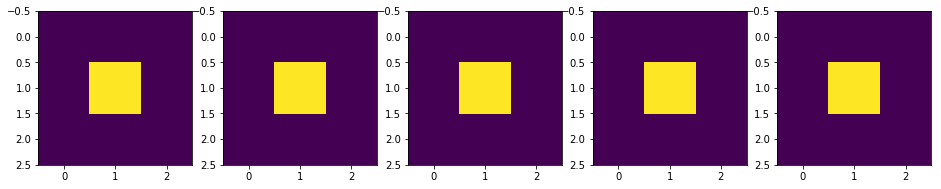

In [38]:
import numpy as np
import tensorflow as tf
from flowdec import tf_ops
from flowdec import data as fd_data
from flowdec import restoration as fd_restoration
from flowdec import validation as fd_validation
from flowdec import exec as tfd_exec
from skimage import restoration as sk_restoration
from skimage.exposure import rescale_intensity

x = np.zeros((3, 3))
x[1, 1] = 1
k = np.zeros((3, 3))
k[1, 1] = 1

# x = np.zeros((9, 9))
# x[3:6, 3:6] = 1
# k = np.zeros((9, 9))
# k[4, 4] = 1

# x = np.zeros((7, 7))
# x[2:5, 2:5] = 1
# k = np.zeros((7, 7))
# k[3, 3] = 1

# x = np.zeros((9, 9))
# x[3:6, 3:6] = 1
# k = np.zeros((7, 7))
# k[2:5, 2:5] = 1

# x = np.zeros((8, 8))
# x[3:5, 3:5] = 1
# k = np.zeros((7, 7))
# k[2:5, 2:5] = 1

# x = np.zeros((9, 9))
# x[3, 4] = 1
# x[4, 3:6] = 1
# x[5, 4] = 1
# k = np.zeros((9, 9))
# k[4, 4] = 1


acq = fd_data.Acquisition(data=x.astype(np.float32), kernel=k.astype(np.float32), actual=x.astype(np.float32))
acq = fd_validation.reblur(acq, scale=0.01)
acq.data = rescale_intensity(acq.data, out_range=(0., 1.))

res = fd_restoration.richardson_lucy(
    acq, 10, pad_mode='log2', real_domain_fft=False, 
    session_config=tf.ConfigProto(device_count={'GPU': 0}))
#res = sk_restoration.richardson_lucy(acq.data, acq.kernel, iterations=10, clip=False)
#res = tfd_exec.run_dl2(acq, 10, 'none')

res_bin = (res > res.mean()).astype(np.int64) 


fig, axs = plt.subplots(1, 5)
fig.set_size_inches(16, 5)
axs[0].imshow(acq.data)
axs[1].imshow(acq.actual)
axs[2].imshow(acq.kernel)
axs[3].imshow(res)
axs[4].imshow(res_bin)

## Simple 3D Shape Test

In [55]:
from nb import utils as nbutils
import imp
imp.reload(fd_restoration)

x = np.zeros((7, 7, 7))
x[2:5, 2:5, 2:5] = 1
k = np.zeros((5, 5, 5))
k[2, 2, 2] = 1

acq = fd_data.Acquisition(data=x.astype(np.float32), kernel=k.astype(np.float32), actual=x.astype(np.float32))
acq = fd_validation.reblur(acq, scale=0.001)
acq.data = rescale_intensity(acq.data, out_range=(0., 1.))

res = fd_restoration.richardson_lucy(
    acq, 10, pad_mode='log2', real_domain_fft=False, 
    session_config=tf.ConfigProto(device_count={'GPU': 0}))
#res = sk_restoration.richardson_lucy(acq.data, acq.kernel, 10)
#res = tfd_exec.run_dl2(acq, 10, 'none')

res_bin = (res > res.mean()).astype(np.int64) 

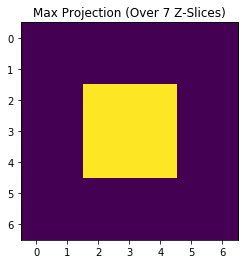

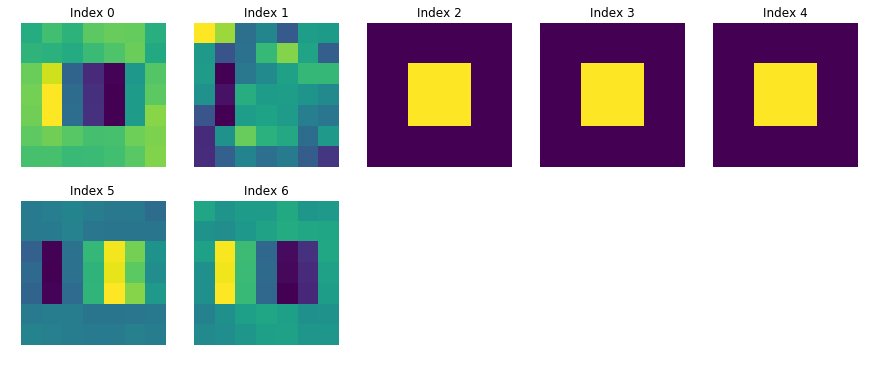

In [56]:
nbutils.plot_img_preview(acq.data)

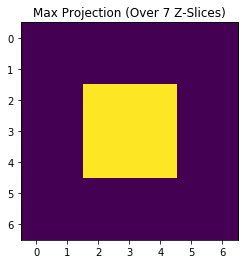

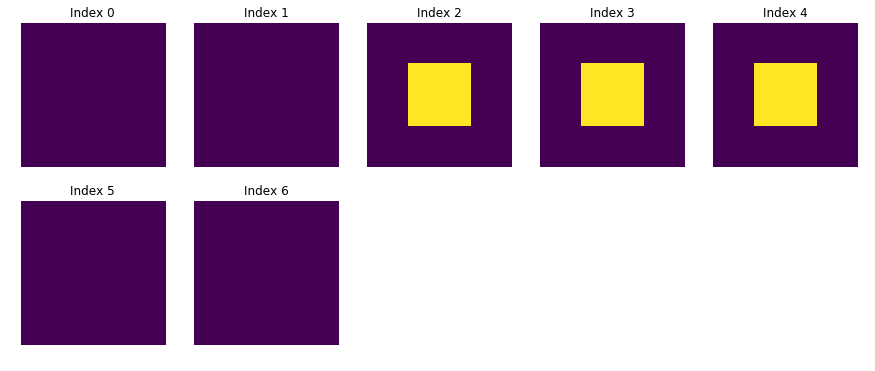

In [58]:
nbutils.plot_img_preview(res)

# Unit Test Case Debugging

In [24]:
# Load data for unit test case currently failing (to investigate)
import pickle
with open('/tmp/flowdec-ut-debug-data.pkl', 'rb') as fd:
    utd = pickle.load(fd)

In [25]:
utd.keys()

dict_keys(['data', 'scores', 'acquisition'])

In [26]:
utd['data'].keys()

dict_keys(['tf', 'sk', 'dl2'])

In [27]:
dacq = {
    'original': utd['acquisition'].actual, 
    'blurred': utd['acquisition'].data,
    'kernel': utd['acquisition'].kernel
}
dalg = {k: utd['data'][k] for k in utd['data'].keys()}
dall = {**dacq, **dalg}

In [28]:
utd['scores']

{'dl2': 0.6007715247551932,
 'original': 0.3875905963304686,
 'sk': 0.5302748919851094,
 'tf': 0.6012137406965922}

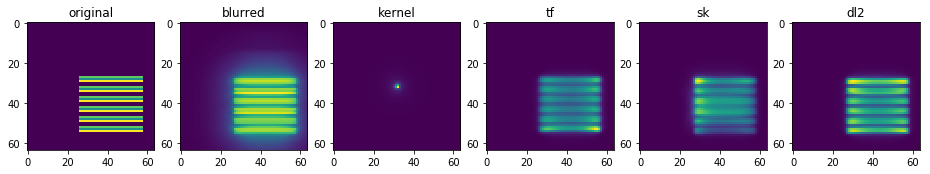

In [29]:
arrs = [(k, dall[k]) for k in dall]

fig, axs = plt.subplots(1, len(arrs))
fig.set_size_inches(16, 5)
for i in range(len(arrs)):
    axs[i].imshow(arrs[i][1].max(axis=0))
    axs[i].set_title(arrs[i][0])

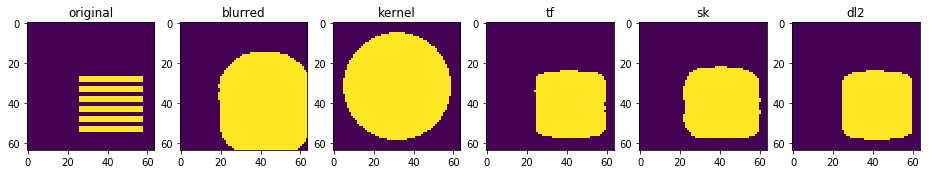

In [30]:
from flowdec.validation import score, binarize
fig, axs = plt.subplots(1, len(arrs))
fig.set_size_inches(16, 5)
for i in range(len(arrs)):
    img = binarize(arrs[i][1]).max(axis=0)
    axs[i].imshow(img)
    axs[i].set_title(arrs[i][0])